# Assignment 1

In this assignment you will be implementing some components of neural networks in numpy from scratch (all your code should be vectorized; and you shouldn’t use any library besides numpy and matplotlib). Base meta classes for the various activations, layers and optimizers are provided; all of your implementations must be classes that inherit from the appropriate base meta class. **When implementing backwards passes, please include in Markdown an analytical derivation of the backwards pass.**

# Step 1: Fully-connected neural networks


## General comments

In this step you will implement all the components you need to construct and train a fully-connected neural network:  the forward and backwards passes for various activations and types of layers, a loss (baked into the SoftMax class), a class to hold the stacked layers together and a couple of optimizers. 

The forward pass is relatively straightforward: each layer outputs an array that the following layer takes as its input. The backwards pass, on the other hand, is a bit more complicated and to be able to complete it, you need to both have the incoming gradient and the original input to each layer, represented by the variable "original_input" in our code. The gradient returned by the backward() call of any given layer is then used as input for the backward() call of the layer immediately preceding it.

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 1. 

Implement the forwards and backwards passes for the following activations: a) Sigmoid, $\sigma(x) = \frac{1}{1+e^{-x}}$; b) Tanh, tthat returns the tangent hyperbolic function of its input,  $y = tanh(x)$. The ReLU class is done for you as an example.

**Note that defining the __ call __ function allows you to avoid calling the forward function directly, i.e. instead of calling ReLU.forward(x), you should call ReLU(x) instead (for example).**

In [2]:
import abc


# Abstract base class for all activation classes
class Activations(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def forward(self, x):
        return

    @abc.abstractmethod
    def backward(self, grad, original_input):
        return


class ReLU(Activations):
    def forward(self, x):
        # return result
        return np.maximum(0, x)

    def backward(self, grad, original_input):
        # this assumes that the original input to this layer has been saved somewhere else
        x = original_input
        return grad * (x > 0)

    def __call__(self, x, mode=None):
        return self.forward(x)


class Sigmoid(Activations):
    def forward(self, x):
        return 1 / (1 + np.exp(-x))

    def backward(self, grad, original_input):
        x = 1/(1 + np.exp(-original_input))
        return grad * (x) * (1 - x)

    def __call__(self, x, mode=None):
        return self.forward(x)


class Tanh(Activations):
    def forward(self, x):
        return np.tanh(x)

    def backward(self, grad, original_input):
        x = np.tanh(original_input)
        return grad * (1 - np.square(x))

    def __call__(self, x, mode=None):
        return self.forward(x)

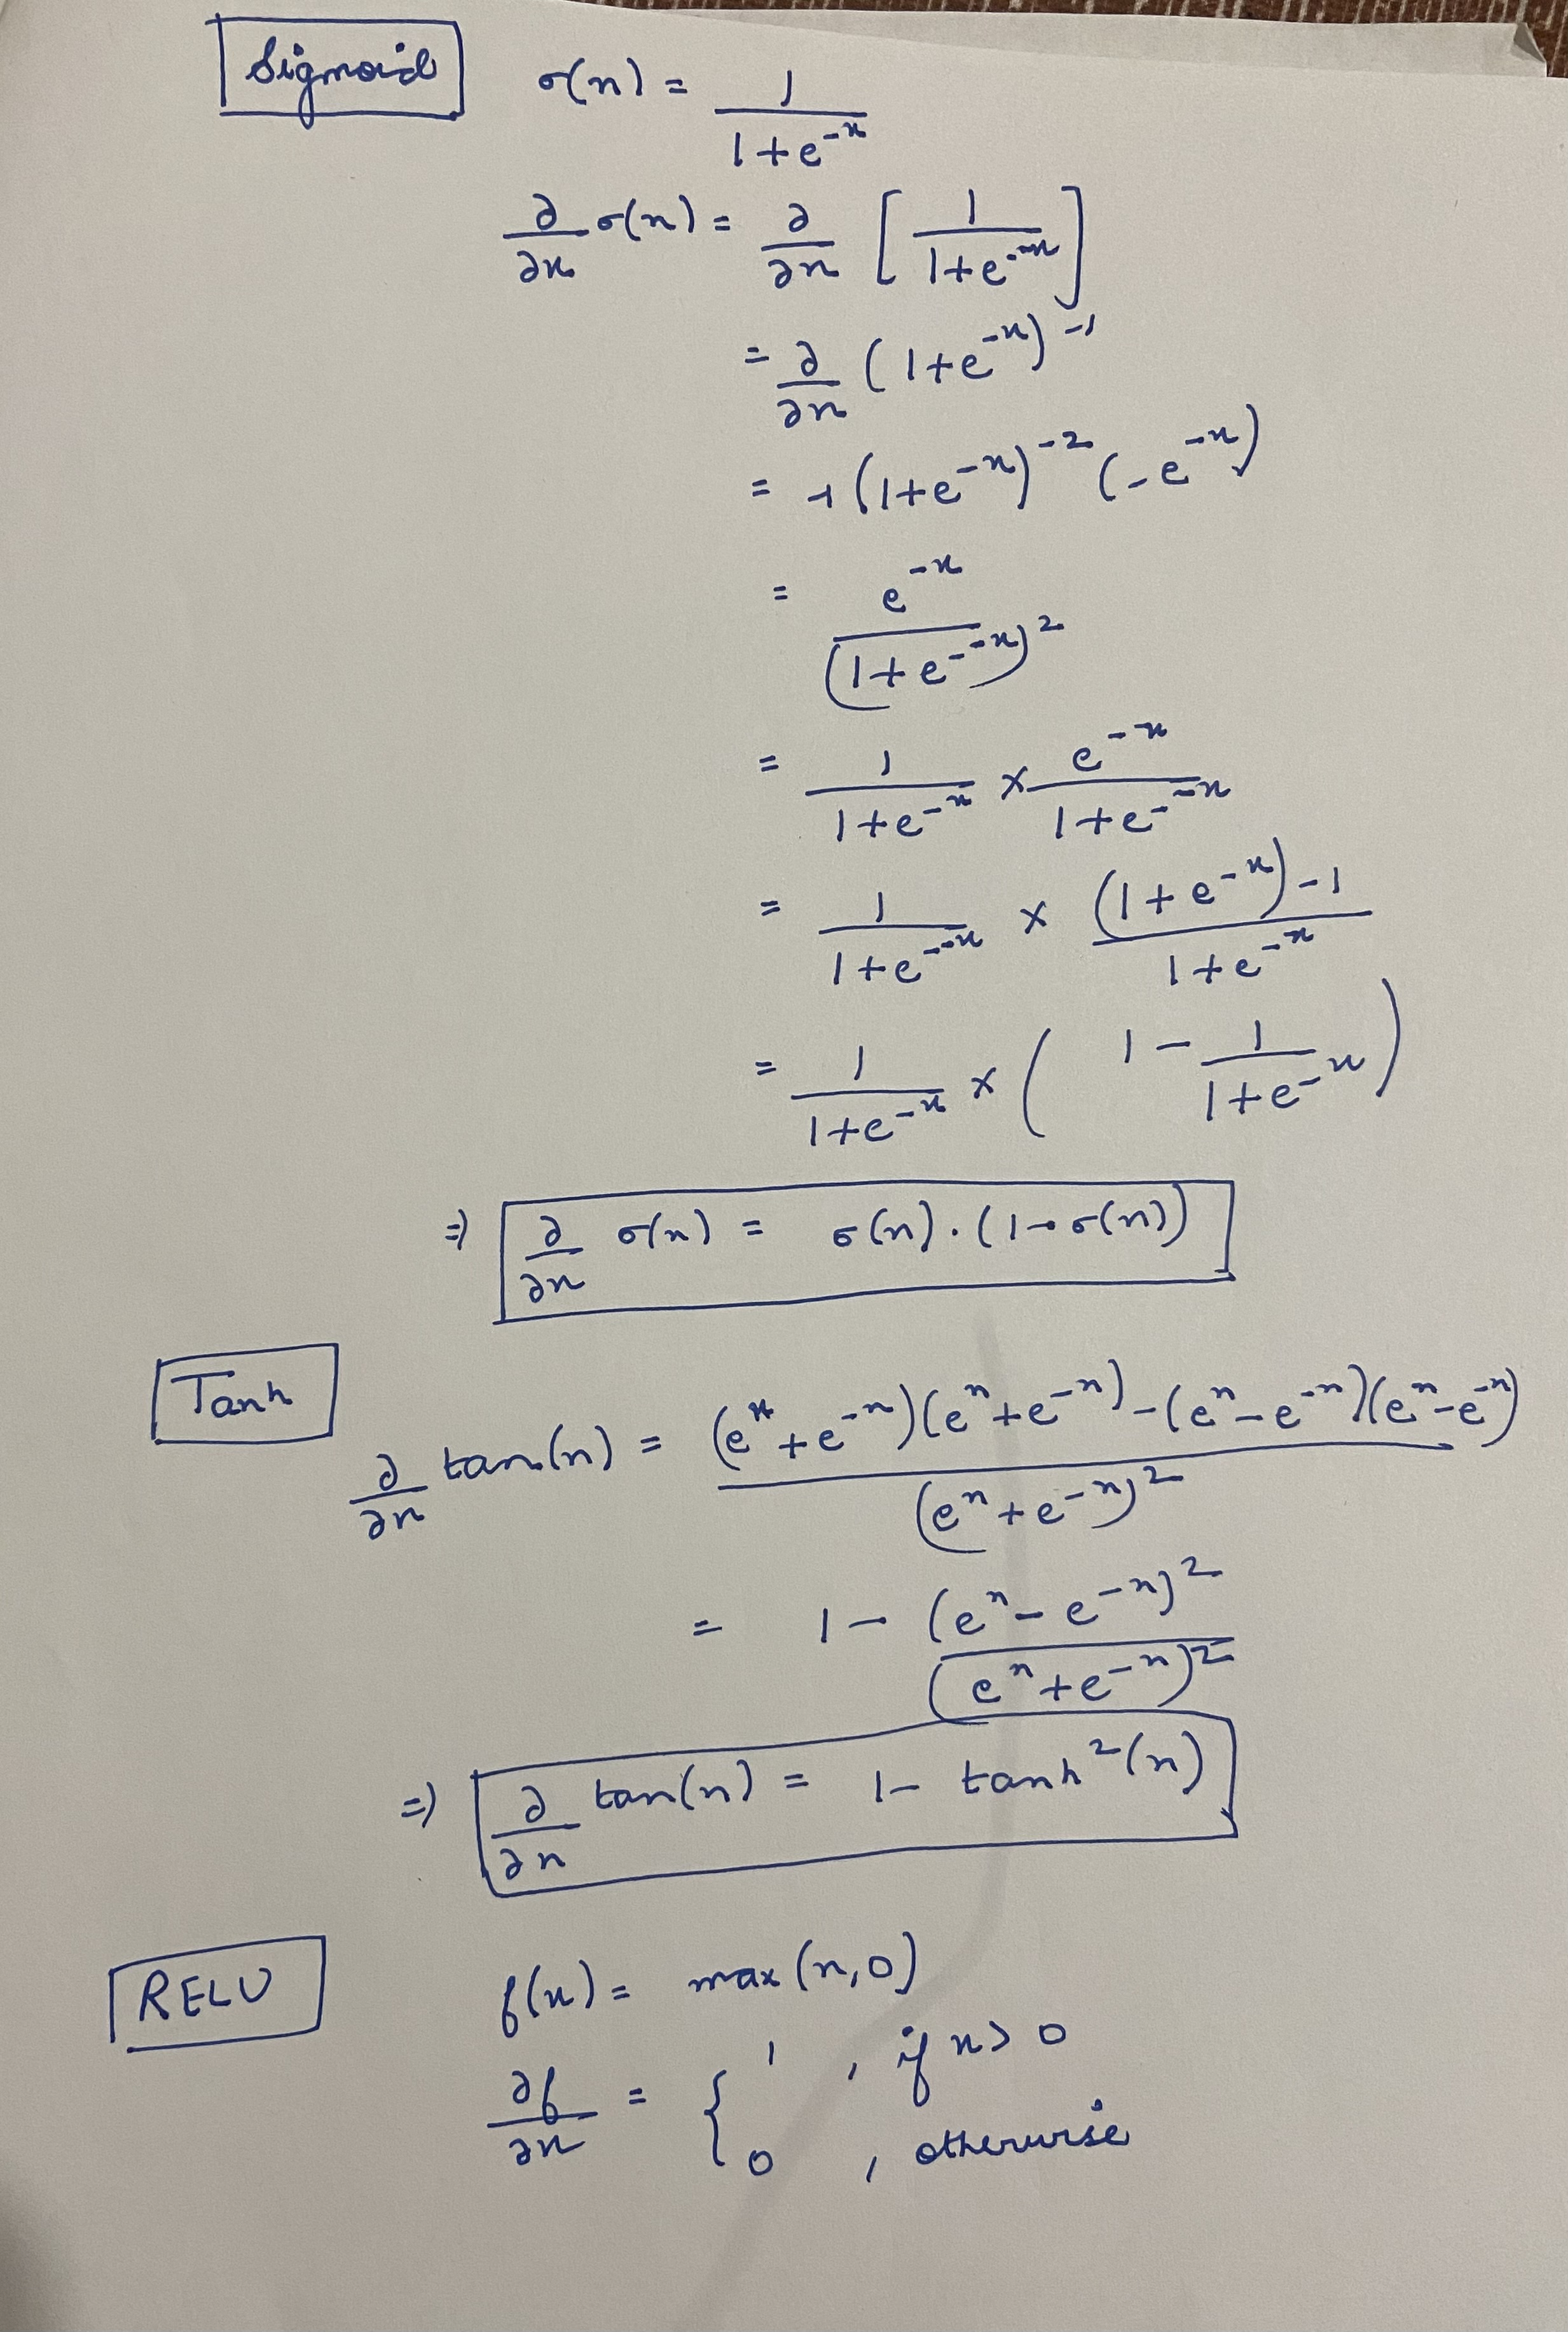

# 2.

Implement an activation (“SoftmaxCrossLoss”) that has two modes of operation: a) if a target, $y_{true}$, is provided then it operates in the same manner as the Pytorch CrossEntropyLoss (https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) (basically the usual softmax activation plus a cross-entropy loss); b) if no target $y_{true}$ is provided, then the forward pass just returns the softmax of the input (no backwards pass needs to be implemented for this mode): for a vector $\mathbf{x}=(x_1,x_2, \cdots, x_n)$, Softmax$(\mathbf{x})_i = \frac{e^{x_i}}{\sum_j e^{x_j}}$ (when using batches this operation should be done for each vector in the batch). 

While implementing softmax shift your input by using shifted_x = x - np.max(x, axis=1, keepdims=True). This does not affect the result of the softmax operation and improves numerical stability.

Note that "mode" is included in this class's function calls just to keep a unified interface for use in the fully-connected neural network.

In [132]:
#y being none should make this return simply a softmax activation: we are in testing mode
#y is not none, you should return the cross-entropy loss using the softmax activations

class SoftMaxCrossLoss(Activations):
    def __init__(self):
        self.probs = None
        self.y = None

    def one_hot(self, Y):
        Y = Y.reshape(Y.shape[0],)
        one_hot_Y = np.zeros((Y.size, 10))
        one_hot_Y[np.arange(Y.size), Y] = 1
        one_hot_Y = one_hot_Y.T
        return one_hot_Y

    def forward(self, x, y=None):
        self.y = y
        expZ = np.exp(x - np.max(x))
        self.probs = expZ / expZ.sum(axis=0, keepdims=True)
        if y is None:
            return self.probs
        else:
            y_size = y.shape[0]
            one_hot_Y = self.one_hot(y)
            self.y = one_hot_Y
            cost = -np.mean(np.multiply(np.log(self.probs), one_hot_Y))
            return cost

    def backward(self, grad, original_input):
        one_hot_Y = self.y
        grad_x = grad * (self.probs - self.y)
        return grad_x

    def __call__(self, x, y=None, mode=None):
        return self.forward(x, y)

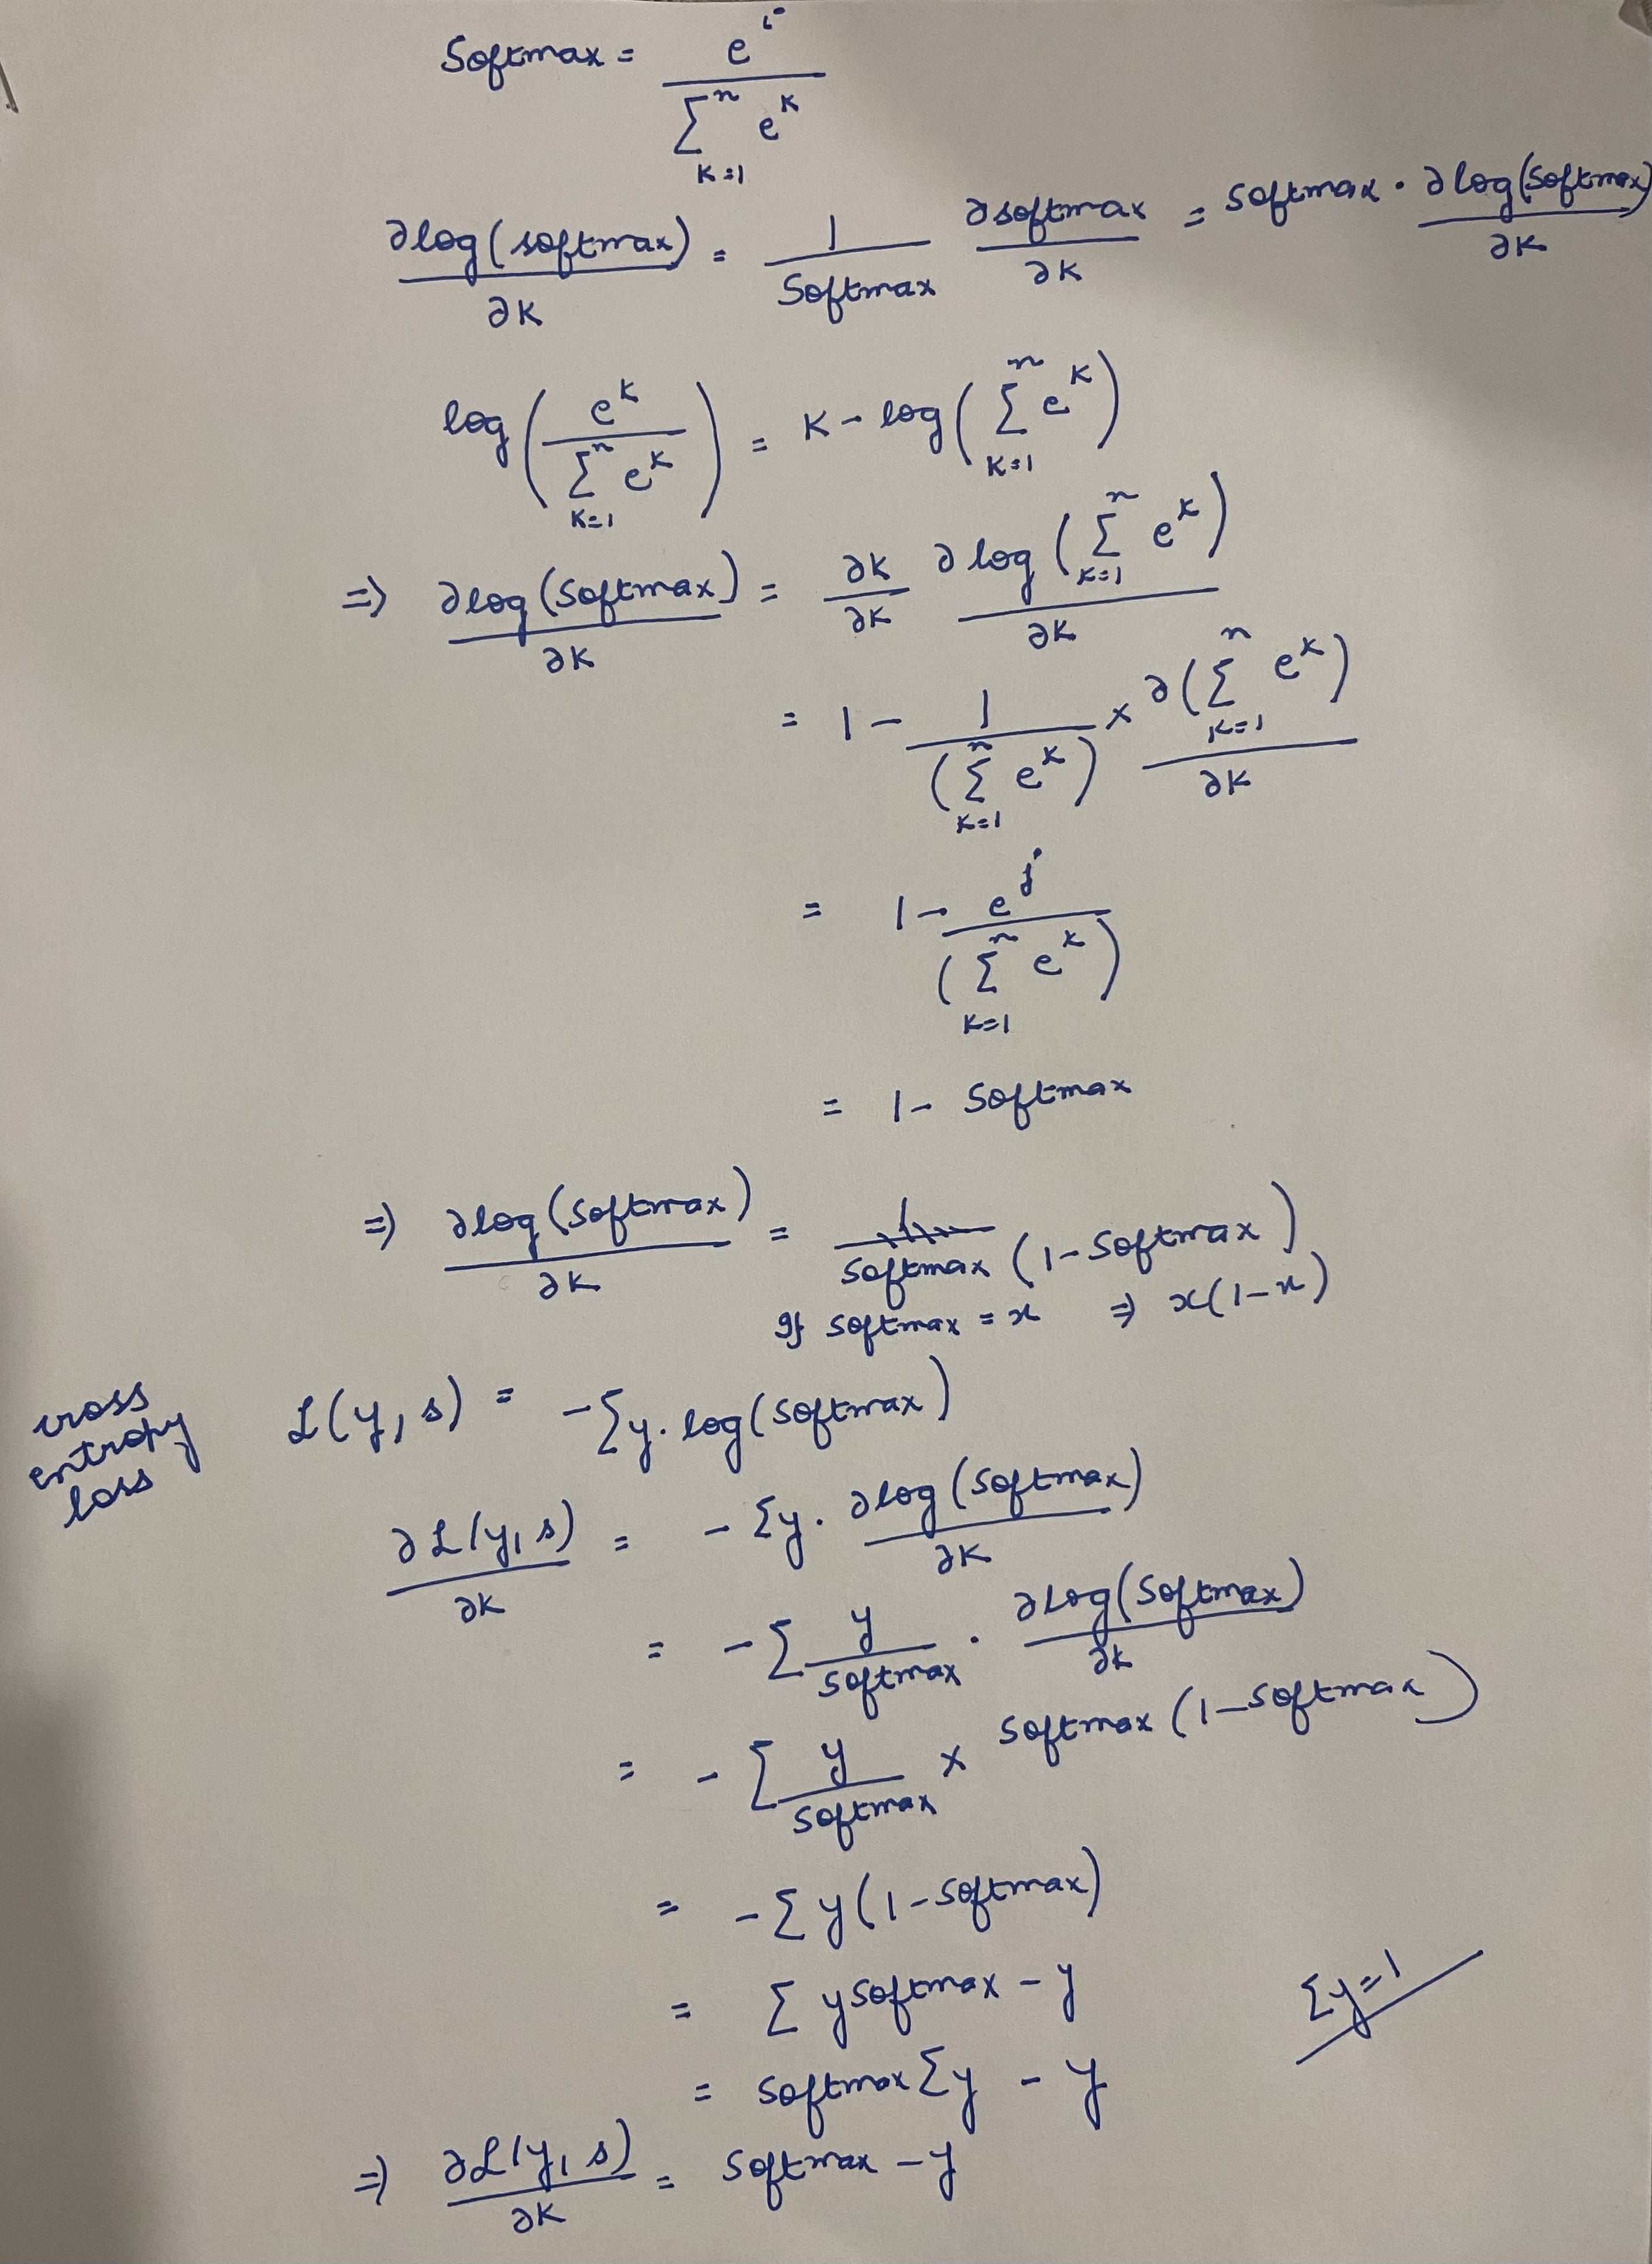

# 3.

Implement three layers (with both forward and backwards passes): a) an AffineLayer (with input dimension input_dim and hidden units hidden_dim), whose forward pass returns $Y=Xw^T + b$, where w and b are the weights and bias respectively; b) an Inverted Dropout (https://machinelearning.wtf/terms/inverted-dropout/) layer that keeps weights with probability p; c) **Only for 6505 students**: a BatchNorm layer.

Note that the gradients of the parameters of each layer should be kept inside their respective layers. Dropout and Batchnorm behave different based on whether we are in "train" or "test" mode.

In [4]:
import abc
class Layers(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def forward(self,x):
        return 
    
    @abc.abstractmethod
    def backward(self, grad,original_input):
        return
        
class AffineLayer(Layers):
    def __init__(self, input_dim, hidden_units):
        ran = np.sqrt(1 / input_dim)

        # Initializing the weights and bias, in that order
        self.parameters = [np.random.uniform(-ran, ran, (hidden_units, input_dim)),
                           np.random.uniform(-ran, ran, hidden_units).reshape(hidden_units,1)]

        self.grads = [np.zeros_like(self.parameters[0]), np.zeros_like(self.parameters[1])]
        self.momentum_l = [np.zeros_like(self.parameters[0]), np.zeros_like(self.parameters[1])] 


    def forward(self, x):
        return self.parameters[0].dot(x) + self.parameters[1]

    def backward(self, grad, original_input):
        m = original_input.shape[0]
        self.grads[0] = 1 / m * grad.dot(original_input.T) 
        self.grads[1] = 1 / m * np.sum(grad)
        return self.parameters[0].T.dot(grad)

    def __call__(self, x, mode=None):
        return self.forward(x)
        
            
class BatchNorm(Layers):
    def _init_(self):
        self.parameters = []
        self.grads = [None] * 2

    def forward(self, x):
        gamma = 1
        beta = 0
        N, D = x.shape
        mu = 1. / N * np.sum(x, axis=0)
        xmu = x - mu
        sq = xmu ** 2
        var = 1. / N * np.sum(sq, axis=0)
        sqrtvar = np.sqrt(var) 
        ivar = 1. / sqrtvar
        xhat = xmu * ivar
        gammax = gamma * xhat
        output = gammax + beta
        self.parameters = [xhat, gamma, xmu, ivar, sqrtvar, var]
        return output

    def backward(self, grad, original_input):
        N, D = grad.shape
        xhat, gamma, xmu, ivar, sqrtvar, var = self.parameters
        dxhat = original_input * gamma
        grad_x = (1. / N) * ivar * (N * dxhat - np.sum(dxhat, axis=0) - xhat * np.sum(dxhat * xhat, axis=0))
        dbeta = np.sum(original_input, axis=0)
        dgamma = np.sum(xhat * original_input, axis=0)

        self.grads[0] = dgamma
        self.grads[1] = dbeta
        return grad * grad_x

    def _call_(self, x, mode=None):
        return self.forward(x)
        
class Dropout(Layers):
    def __init__(self, p):
        self.p = p
        self.mask = None

    def forward(self, x, mode):
        if mode == "train":
            self.mask = np.random.uniform(low=0., high=1., size=x.shape) > self.p
            return (self.mask * x) / (1 - self.p)
        else:
            return x

    def backward(self, grad, original_input):
        grad_x = grad * (self.mask) / (1 - self.p)
        return grad_x

    def __call__(self, x, mode=None):
        return self.forward(x, mode)
    

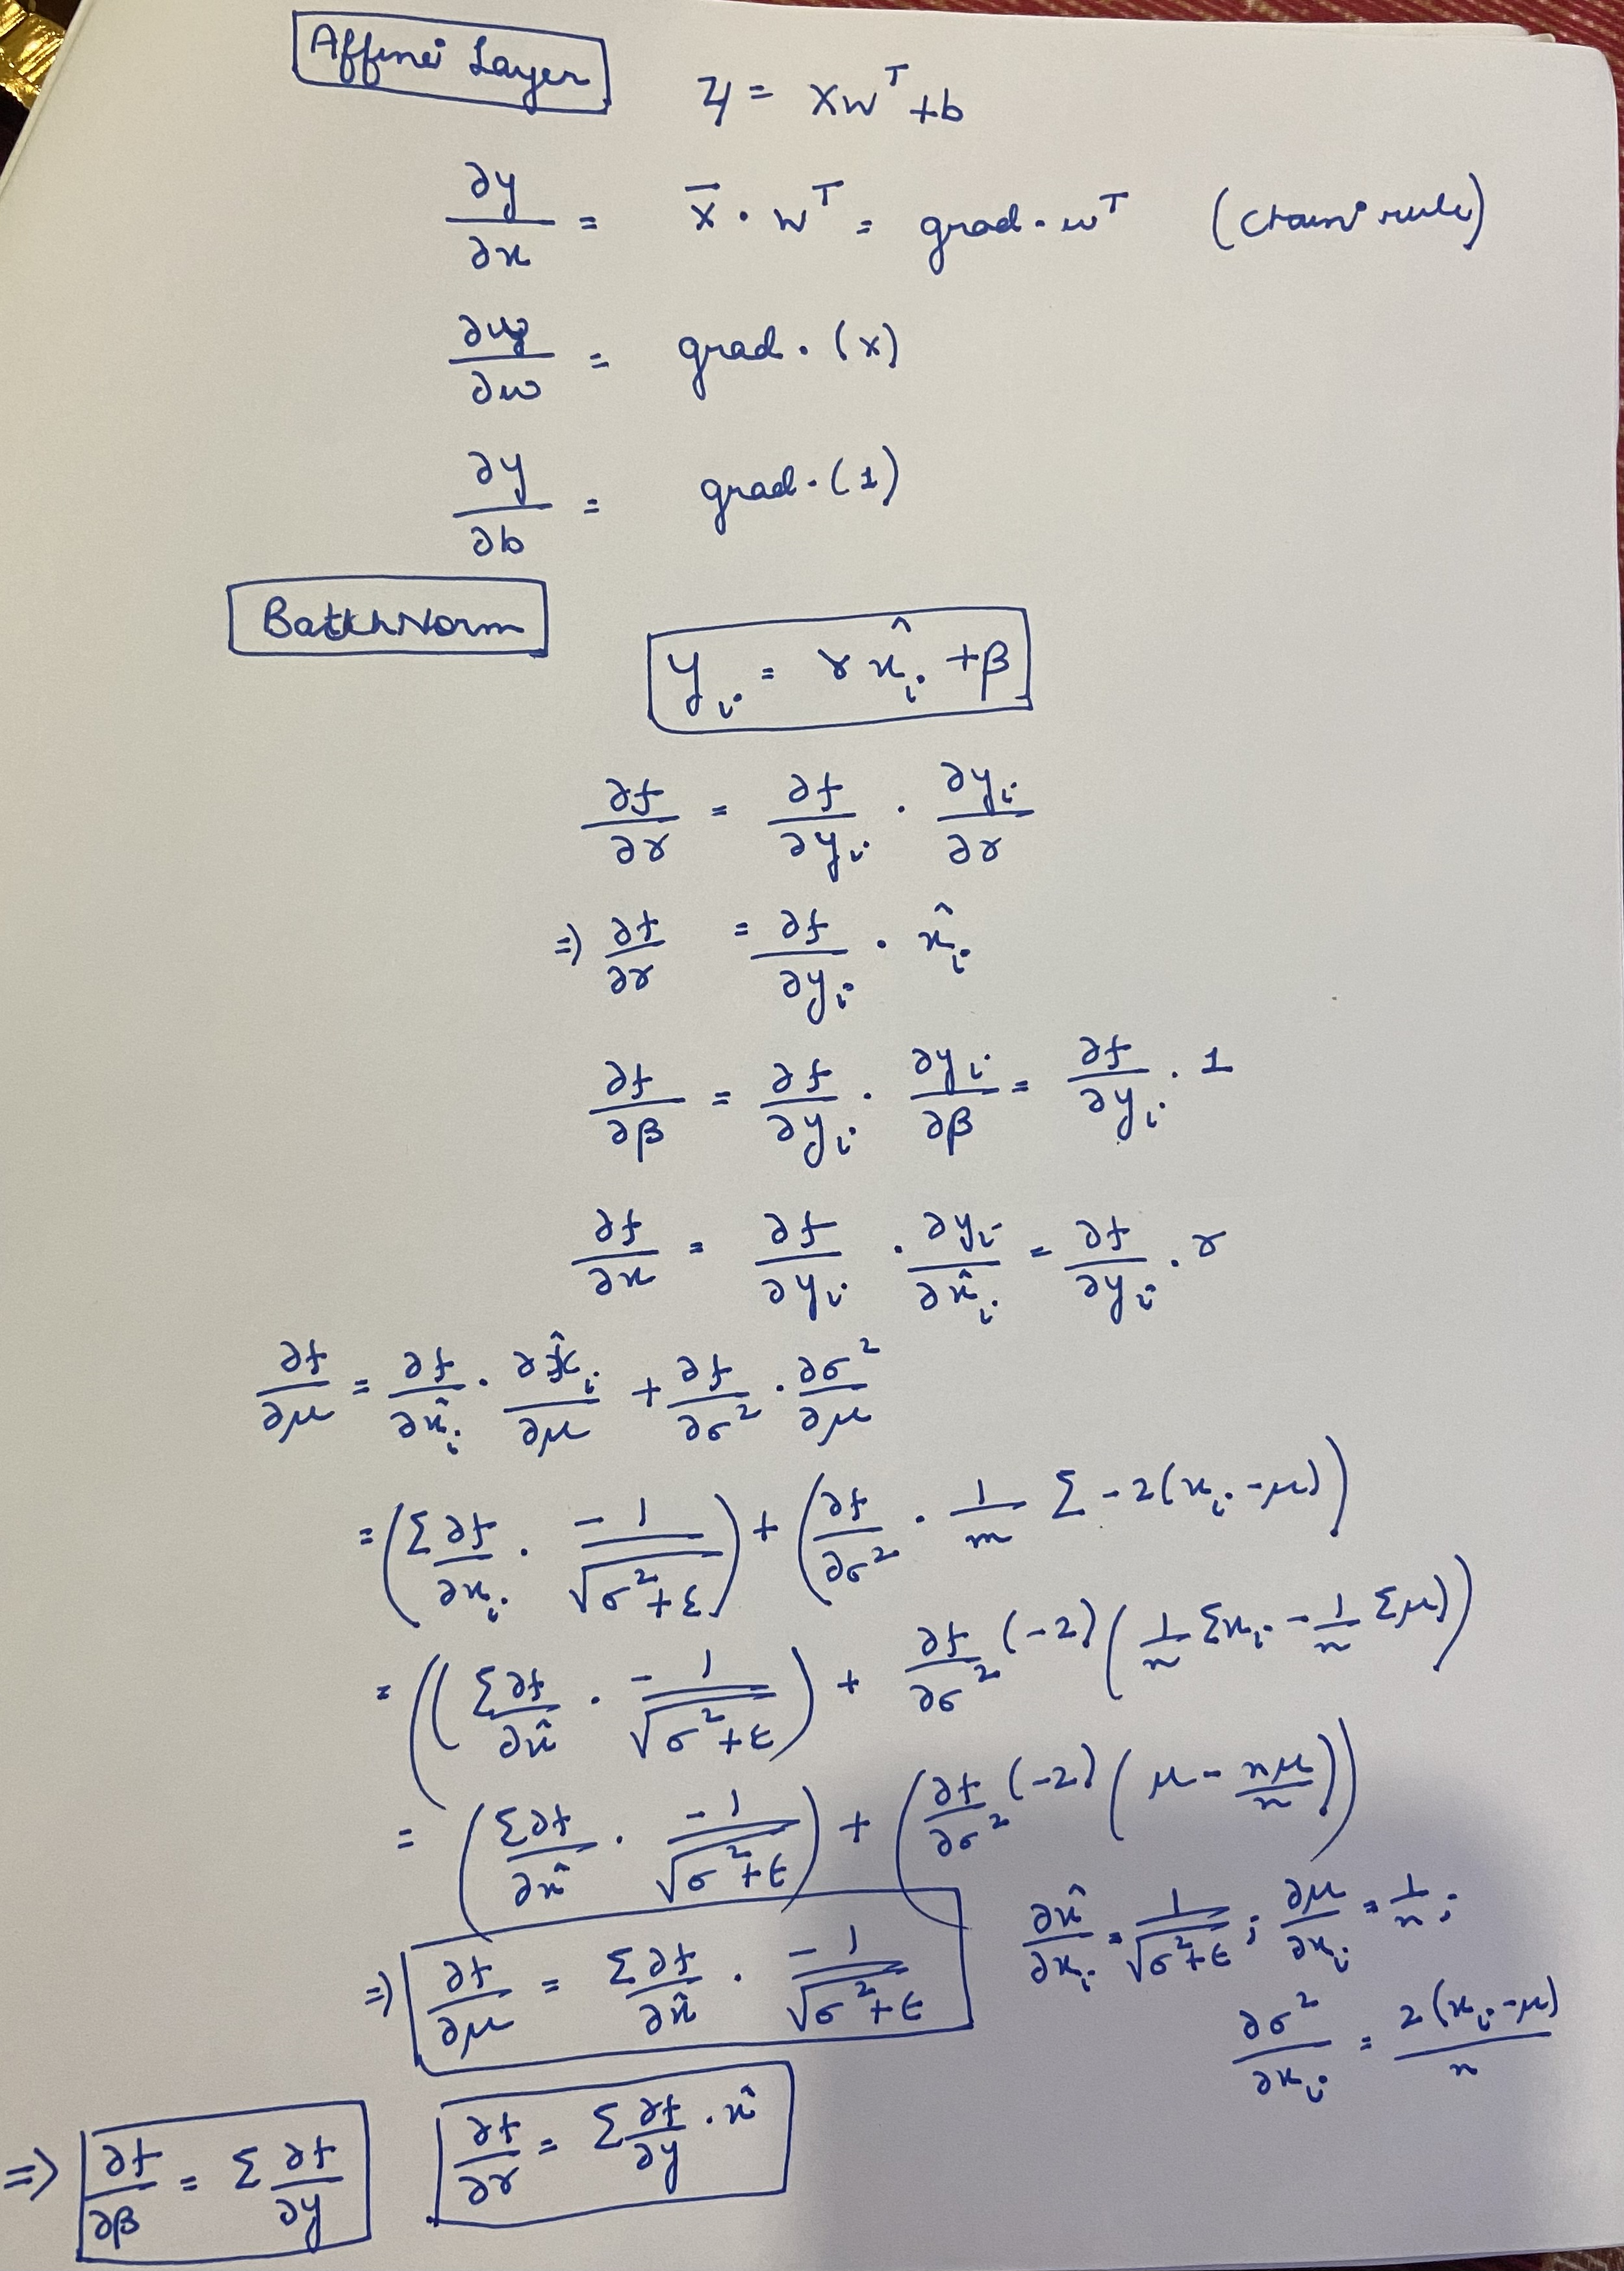

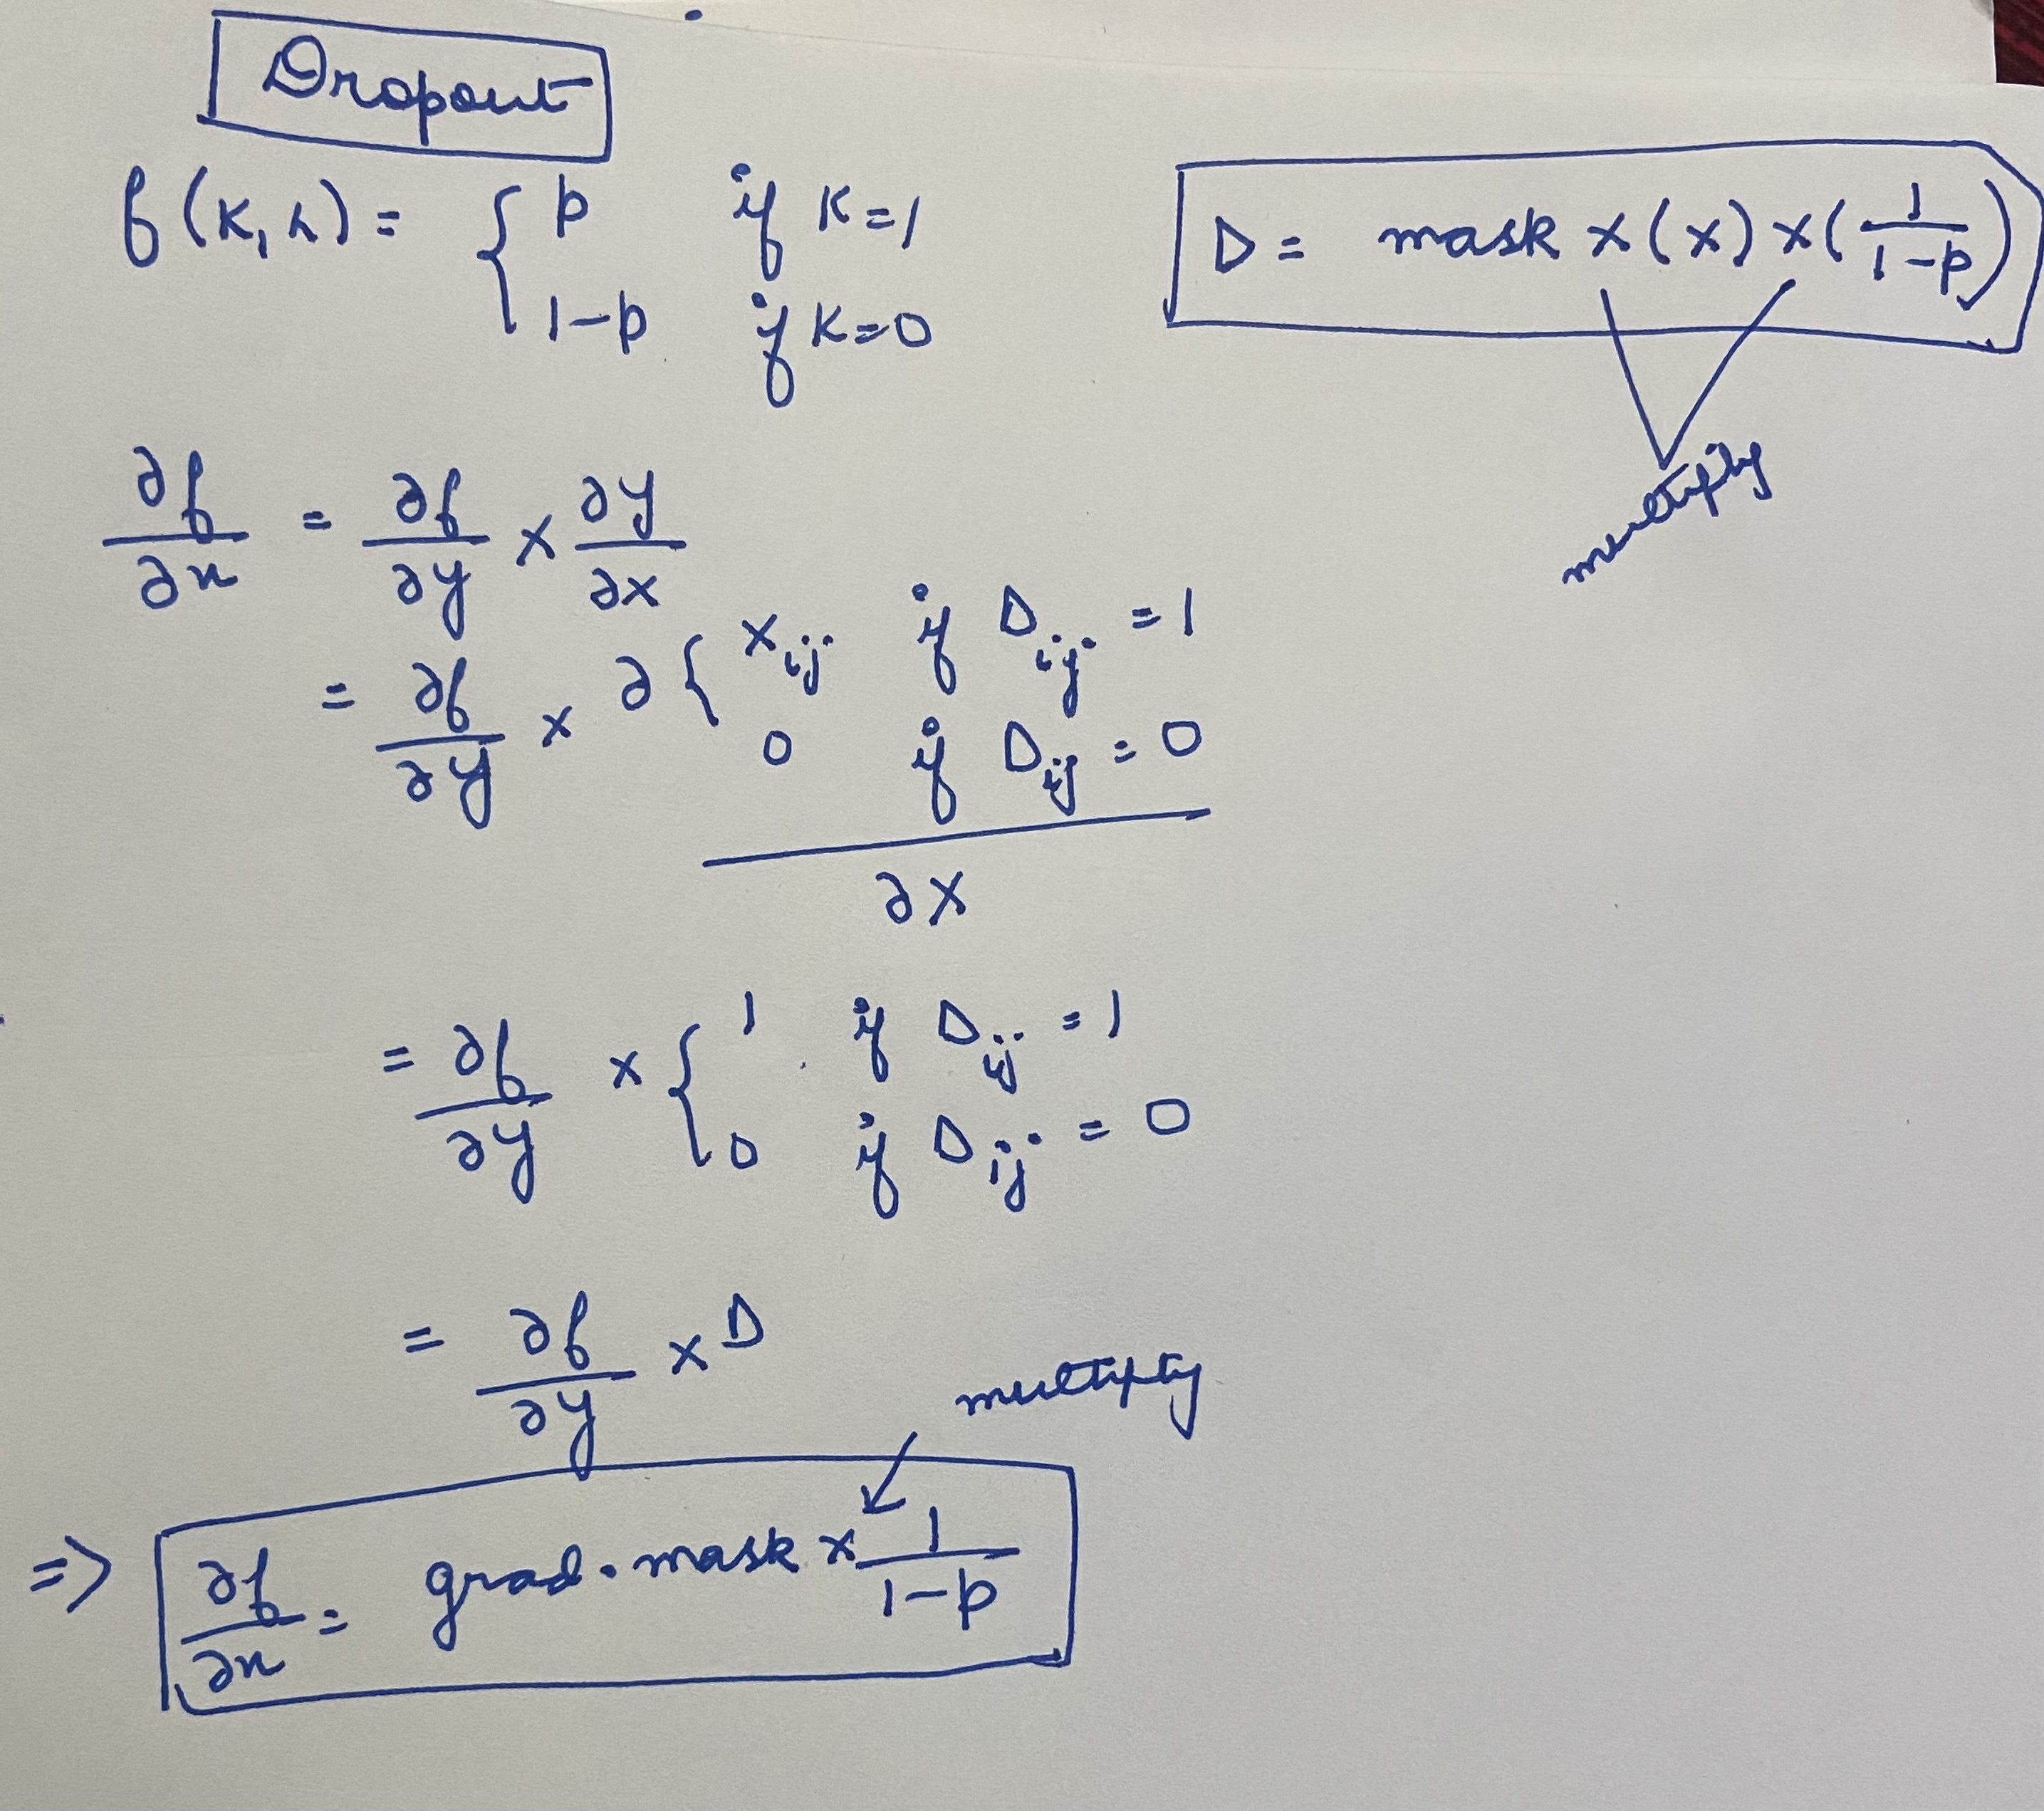

# 4.

Implement a fully connected neural network that takes as input some user-defined layers and has both forward and backward passes (you should use the forward and backward passes from the previously defined layers).

In [5]:
class FCNN:
    def __init__(self, layers):
        self.layers = layers
        self.original_inputs = []

    def forward(self, x, y=None, mode='test'):
        self.original_inputs = [x.copy()]
        for i in range(len(self.layers)):
            curr_layer = self.layers[i]
            if isinstance(curr_layer, SoftMaxCrossLoss):
                curr_layer_output = curr_layer(self.original_inputs[i], y)
            elif isinstance(curr_layer, Dropout):
                curr_layer_output = curr_layer(self.original_inputs[i], mode=mode)
            else:
                curr_layer_output = curr_layer(self.original_inputs[i])
            self.original_inputs.append(curr_layer_output)
        return self.original_inputs.pop()

    def backward(self):
        grad = 1
        for i in range(len(self.layers) - 1, -1, -1):
            grad = self.layers[i].backward(grad, self.original_inputs.pop())
        return grad

    def __call__(self, x, y=None, mode='test'):
        return self.forward(x, y, mode)

# 5.

Implement the following optimizers: a) stochastic gradient descent with momentum; b) **Only for 6505 students**: the Adam optimizer (https://pytorch.org/docs/stable/generated/torch.optim.Adam.html). These optimizers should take as input a layer and update their parameters according to the gradients stored in the layers.

Note that Adam requires you to keep a track of the running means of gradients. A python dictionary to organize this might prove useful.

In [160]:
class Optimizer(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def step(self, layer):
        return


class SGD(Optimizer):
    def __init__(self, momentum, alpha):
        self.alpha = alpha 
        self.momentum = momentum

    def step(self, layer):
        layer.momentum_l[0] = self.momentum * layer.momentum_l[0] + layer.grads[0]
        layer.momentum_l[1] = self.momentum * layer.momentum_l[1] + layer.grads[1]
        layer.parameters[0] -= self.alpha * layer.momentum_l[0]
        layer.parameters[1] -= self.alpha * layer.momentum_l[1]

# 6.

Test out several fully connected architectures on the reduced MNIST dataset provided. Feed the dataset to your network in batches and experiment with the batch size. 

a) Experiment with the batch size. Does the batch size impact performance? 

b) Do you do better with two or three layers? Experiment with the hidden units in each layers.

c) Does adding more layers continually improve your results? 

d) Does Dropout help? 

e) What can you say about the difficulty of training as you add layers? 

f) **Only for 6505 students**: Does Batchnorm improve results? 

g) **Only for 6505 students**: Try using the Adam optimizer. Do you converge more quickly? Do you get better results?




**Download train.npz and test.npz from the Assignment 1 Files folder on teams. The data contains several thousand images represented by arrays of shape (28,28); before feeding it to your network you should flatten them so that each image has shape (784,).**

In [7]:
def get_prediction(y_pred):
    return np.argmax(y_pred, 0)

In [8]:
def get_accuracy(predictions, Y_target):
    return np.sum(predictions == Y_target) / Y.size

WITHOUT DROPOUT LAYER

In [161]:
# Loading the data

train_data = np.load(r"train.npz")['arr_0']
train_targets = np.load(r"train.npz")['arr_1']

test_data = np.load(r"test.npz")['arr_0']
test_targets = np.load(r"test.npz")['arr_1']

# Define your batch size
batch_size = 20

# flattening x

train_data_flattened = train_data.reshape(len(train_data), 28 * 28)
test_data_flattened = test_data.reshape(len(test_data), 28 * 28)
train_targets = train_targets.reshape(train_targets.shape[0], 1)

n = 0
batch_size = 20
cost_array = []

epochs = int(train_targets.size/batch_size)

net = FCNN([AffineLayer(784, 128), Tanh(), AffineLayer(128, 10), SoftMaxCrossLoss()])


# model train
for i in range(epochs):
    
    train_data_flattened_batch = train_data_flattened[n : n + batch_size]
    train_targets_batch = train_targets[n : n + batch_size]
    
    n = n + batch_size

    train_data_flattened_batch.T

    cost = net(train_data_flattened_batch.T, train_targets_batch, mode = "train")
    cost_array.append(cost)
    backward_prop = net.backward()
    
    optimizer = SGD(momentum=0.9, alpha=0.1)
    
    if i > 0 and i % batch_size-1 == 0:
        for i_layer in net.layers[::-1]:
            if str(type(i_layer)) == "<class '__main__.AffineLayer'>":              
                optimizer.step(i_layer)
                

                
# model test
len(cost_array)
n = 0
batch_test_size = 100
while(n < test_targets.size):
    test_data_flattened_batch = test_data_flattened[n:n + batch_test_size]
    test_targets_batch = test_targets[n:n + batch_test_size]

    cost_test = net(test_data_flattened_batch.T)
    n = n + batch_test_size
    
    if (n % 1000 == 0):
        pred = np.argmax(cost_test, axis=0)
        print("Accuracy at ",n,": ",str((np.sum(test_targets_batch == pred) / test_targets_batch.size)*100))

Accuracy at  1000 :  92.0
Accuracy at  2000 :  87.0
Accuracy at  3000 :  90.0
Accuracy at  4000 :  88.0
Accuracy at  5000 :  92.0
Accuracy at  6000 :  82.0
Accuracy at  7000 :  89.0
Accuracy at  8000 :  81.0
Accuracy at  9000 :  81.0
Accuracy at  10000 :  89.0


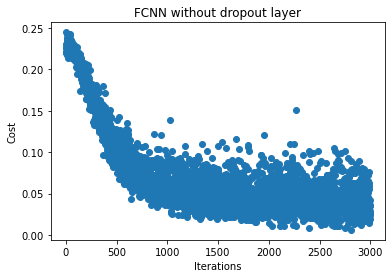

In [162]:
plt.scatter(np.arange(epochs),cost_array)
plt.title('FCNN without dropout layer')
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()

In [164]:
# Loading the data

train_data = np.load(r"train.npz")['arr_0']
train_targets = np.load(r"train.npz")['arr_1']

test_data = np.load(r"test.npz")['arr_0']
test_targets = np.load(r"test.npz")['arr_1']

# Define your batch size
batch_size = 20

# flattening x

train_data_flattened = train_data.reshape(len(train_data), 28 * 28)
test_data_flattened = test_data.reshape(len(test_data), 28 * 28)
train_targets = train_targets.reshape(train_targets.shape[0], 1)

n = 0
batch_size = 20
cost_array = []

epochs = int(train_targets.size/batch_size)

net = FCNN([AffineLayer(784, 128), Tanh(), AffineLayer(128, 10), Tanh(), AffineLayer(10, 10), SoftMaxCrossLoss()])


# model train
for i in range(epochs):
    
    train_data_flattened_batch = train_data_flattened[n : n + batch_size]
    train_targets_batch = train_targets[n : n + batch_size]
    
    n = n + batch_size

    train_data_flattened_batch.T

    cost = net(train_data_flattened_batch.T, train_targets_batch, mode = "train")
    cost_array.append(cost)
    backward_prop = net.backward()
    
    optimizer = SGD(momentum=0.9, alpha=0.1)
    
    if i > 0 and i % batch_size-1 == 0:
        for i_layer in net.layers[::-1]:
            if str(type(i_layer)) == "<class '__main__.AffineLayer'>":              
                optimizer.step(i_layer)
                

                
# model test
len(cost_array)
n = 0
batch_test_size = 100
while(n < test_targets.size):
    test_data_flattened_batch = test_data_flattened[n:n + batch_test_size]
    test_targets_batch = test_targets[n:n + batch_test_size]

    cost_test = net(test_data_flattened_batch.T)
    n = n + batch_test_size
    
    if (n % 1000 == 0):
        pred = np.argmax(cost_test, axis=0)
        print("Accuracy at ",n,": ",str((np.sum(test_targets_batch == pred) / test_targets_batch.size)*100))

Accuracy at  1000 :  87.0
Accuracy at  2000 :  83.0
Accuracy at  3000 :  85.0
Accuracy at  4000 :  84.0
Accuracy at  5000 :  86.0
Accuracy at  6000 :  73.0
Accuracy at  7000 :  86.0
Accuracy at  8000 :  77.0
Accuracy at  9000 :  78.0
Accuracy at  10000 :  79.0


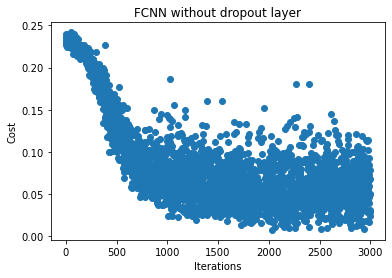

In [165]:
plt.scatter(np.arange(epochs),cost_array)
plt.title('FCNN without dropout layer')
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()

<b> Network with multiple layers, model starts to overfit.
Therefore, accuracy decreases </b>

WITH DROPOUT LAYER

In [168]:
# Loading the data

train_data = np.load(r"train.npz")['arr_0']
train_targets = np.load(r"train.npz")['arr_1']

test_data = np.load(r"test.npz")['arr_0']
test_targets = np.load(r"test.npz")['arr_1']

# Define your batch size
batch_size = 20

# flattening x

train_data_flattened = train_data.reshape(len(train_data), 28 * 28)
test_data_flattened = test_data.reshape(len(test_data), 28 * 28)
train_targets = train_targets.reshape(train_targets.shape[0], 1)

n = 0
batch_size = 20
cost_array = []

epochs = int(train_targets.size/batch_size)

net = net = FCNN([AffineLayer(784, 128), Tanh(), Dropout(0.1), AffineLayer(128, 10), Sigmoid(), 
            Dropout(0.1), AffineLayer(10, 10), SoftMaxCrossLoss()])


# model train
for i in range(epochs):
    
    train_data_flattened_batch = train_data_flattened[n : n + batch_size]
    train_targets_batch = train_targets[n : n + batch_size]
    
    n = n + batch_size

    train_data_flattened_batch.T

    cost = net(train_data_flattened_batch.T, train_targets_batch, mode = "train")
    cost_array.append(cost)
    backward_prop = net.backward()
    
    optimizer = SGD(momentum=0.9, alpha=0.1)
    
    if i > 0 and i % batch_size-1 == 0:
        for i_layer in net.layers[::-1]:
            if str(type(i_layer)) == "<class '__main__.AffineLayer'>":              
                optimizer.step(i_layer)
                

                
# model test
len(cost_array)
n = 0
batch_test_size = 100
while(n < test_targets.size):
    test_data_flattened_batch = test_data_flattened[n:n + batch_test_size]
    test_targets_batch = test_targets[n:n + batch_test_size]

    cost_test = net(test_data_flattened_batch.T)
    n = n + batch_test_size
    
    if (n % 1000 == 0):
        pred = np.argmax(cost_test, axis=0)
        print("Accuracy at ",n,": ",str((np.sum(test_targets_batch == pred) / test_targets_batch.size)*100))


Accuracy at  1000 :  84.0
Accuracy at  2000 :  80.0
Accuracy at  3000 :  73.0
Accuracy at  4000 :  77.0
Accuracy at  5000 :  81.0
Accuracy at  6000 :  66.0
Accuracy at  7000 :  82.0
Accuracy at  8000 :  71.0
Accuracy at  9000 :  72.0
Accuracy at  10000 :  79.0


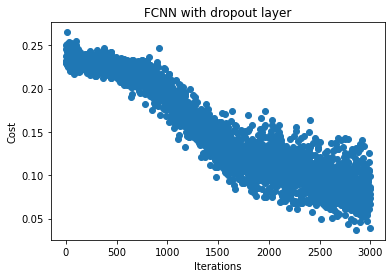

In [169]:
plt.scatter(np.arange(epochs),cost_array)
plt.title('FCNN with dropout layer')
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()

<b> Therefore, Network without Dropout performs better at the training phase while network with drop layer doesn't perform better </b>

With Batch Norm

In [171]:
# Loading the data

train_data = np.load(r"train.npz")['arr_0']
train_targets = np.load(r"train.npz")['arr_1']

test_data = np.load(r"test.npz")['arr_0']
test_targets = np.load(r"test.npz")['arr_1']

# Define your batch size
batch_size = 20

# flattening x

train_data_flattened = train_data.reshape(len(train_data), 28 * 28)
test_data_flattened = test_data.reshape(len(test_data), 28 * 28)
train_targets = train_targets.reshape(train_targets.shape[0], 1)

curr_pos = 0
batch_size = 20
cost_array = []

epochs = int(train_targets.size/batch_size)
alpha = 0.001

net = FCNN([AffineLayer(784, 128), Tanh(), BatchNorm(), AffineLayer(128, 10), SoftMaxCrossLoss()])

for i in range(epochs):
    train_data_flattened_batch = train_data_flattened[curr_pos : curr_pos + batch_size]
    train_targets_batch = train_targets[curr_pos : curr_pos + batch_size]
    curr_pos = curr_pos + batch_size

    train_data_norm = train_data_flattened
    test_data_norm = test_data_flattened
    X = train_data_flattened_batch.T

    output_probs = net(X, train_targets_batch, mode = "train")
    cost_array.append(output_probs)
    backward_prop = net.backward()
    optimizer = SGD(momentum=0.9, alpha=0.1)
    
    if i>0 and i%batch_size-1 == 0:
        for i_layer in net.layers[::-1]:
            if str(type(i_layer)) == "<class '__main__.AffineLayer'>":
                before_params = i_layer.parameters               
                optimizer.step(i_layer)
                after_params = i_layer.parameters

len(cost_array)
curr_pos=0
batch_test_size=100
while(curr_pos < test_targets.size):
    test_data_flattened_batch = test_data_flattened[curr_pos:curr_pos + batch_test_size]
    test_targets_batch = test_targets[curr_pos:curr_pos + batch_test_size]
    X_1 = test_data_flattened_batch.T
    output_probs_test = net(X_1)
    curr_pos = curr_pos + batch_test_size
    
    if (curr_pos % 1000 == 0):
        pred = np.argmax(output_probs_test, axis=0)
        print("Accuracy at ",curr_pos,": ",str((np.sum(test_targets_batch == pred) / test_targets_batch.size)*100))

Accuracy at  1000 :  90.0
Accuracy at  2000 :  85.0
Accuracy at  3000 :  82.0
Accuracy at  4000 :  86.0
Accuracy at  5000 :  92.0
Accuracy at  6000 :  76.0
Accuracy at  7000 :  87.0
Accuracy at  8000 :  81.0
Accuracy at  9000 :  76.0
Accuracy at  10000 :  86.0


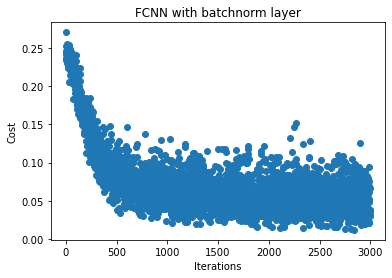

In [172]:
plt.scatter(np.arange(epochs),cost_array)
plt.title('FCNN with batchnorm layer')
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()

<b> Therefore, because of batch normalization, where we normalize the inputs, the network trains faster.
and it provides a bit of regularization </b>